# Mandatory Assignment 1

#### Part I: Multi-layer Perceptron

***

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebook**: [material/nns_pytorch.ipynb](material/nns_pytorch.ipynb)

Table of contents:
1. Activate GPU
2. Load data
3. Inspect data
4. Artificial neural network (**Where you will implement the ANN**)
5. Training hyperparameters (**Where you will add training parameters**)
6. Training
7. Plot loss and accuracy
8. Evaluate


In [1]:
# auxilary imports
import random
import matplotlib.pyplot as plt
import os
from pathlib import Path

# pytorch
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F  # noqa

Matplotlib is building the font cache; this may take a moment.


First, a bit of a hack in case your IDE wants to run the notebook from /`assignment/` and not the project root folder `/ma1`. We need the working directory to be `/ma1` for local imports to work.

In [2]:
# Ensure the working directory is set to the "ma1" folder.
while Path.cwd().name != "ma1" and "ma1" in str(Path.cwd()):
    os.chdir("..")  # Move up one directory
print(f"Working directory set to: {Path.cwd()}")

Working directory set to: /Users/vincentpedersen/Desktop/Uni/AIML25/mas/ma1


##### Import local files

To declutter the notebooks, your are given a module (`/src`) of useful functions. Please study each one as they contain important code (particularly `src.training` and `src.evaluation`). 

In [3]:
# local files
from src.utils import get_device
from src.data import load_torch_data, to_dataloader, train_val_split
from src.training import fit
from src.evaluation import evaluate
from src.visualize import plot_training_history

### 1. Activate GPU
If available. Note that this is not necessary, but it will speed up your training.

In [4]:
# Device will determine whether to run the training on GPU or CPU.
DEVICE = get_device()

Running pytorch version (2.5.1) with backend = cpu


### 2. Load data

In [5]:
# load the training/validation data
train_val = load_torch_data(
    dataset="MNIST",
    root = 'data',                     # The root directory where the dataset will be stored
    download = True,                   # If the dataset is not found at root, it will be downloaded
    train = True,                      # The train dataset (as opposed to the test dataset)
    transform = transforms.ToTensor()  # transformations to be applied to the dataset (only cast to tensor)
)

# load the testing data
test = load_torch_data(
    dataset = "MNIST",
    root = 'data',
    download = True,
    train = False,
    transform = transforms.ToTensor()
)

f"{len(train_val)=}, {len(test)=}"

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:03<00:00, 3.20MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 282kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.43MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 930kB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



'len(train_val)=60000, len(test)=10000'

In [6]:
# split training data in training and validation (just like train_test_split in sklearn)
train, val = train_val_split(train_val, val_ratio=0.2, seed=42)

f"{len(val)=}, {len(train)=}"

'len(val)=12000, len(train)=48000'

In [7]:
# create dataloders for easy batch loading during training
train_loader = to_dataloader(train, batch_size = 64, shuffle = True)
val_loader = to_dataloader(val, batch_size = 64, shuffle = False)
test_loader = to_dataloader(test, batch_size = 64, shuffle = False)

### 3. Inspect data

Default image shape: torch.Size([1, 28, 28])
Reshaped image shape: torch.Size([28, 28])
Total pixels: 784
The label for this image: 9


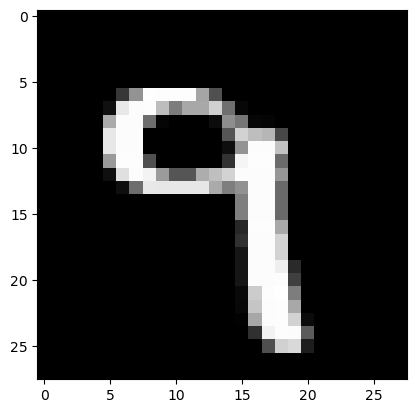

In [8]:
# Pick a random example from the training set
selection = random.randrange(len(train)-1)
image, label = train[selection]

# Plot the image
print(f"Default image shape: {image.shape}")
image = image.view([28,28])

print(f"Reshaped image shape: {image.shape}")
plt.imshow(image, cmap="gray")

print(f"Total pixels: {image.shape[0] * image.shape[1]}")

# Print the label
print(f"The label for this image: {label}")


***

### 4. Artificial neural network

In [64]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):

  def __init__(self):
    super().__init__()

     # Define the layers
    self.fc1 = nn.Linear(784, 500)
    self.fc2 = nn.Linear(500, 128)
    self.fc3 = nn.Linear(128,64)
    self.fc4 = nn.Linear(64, 10)


  def forward(self, x : torch.Tensor):

    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.softmax(x,dim=1)
    x = self.fc4(x)
    return x

### 5. Training hyperparameters

In [65]:
LR = 0.001  
NUM_EPOCHS = 25 
criterion = nn.CrossEntropyLoss()  # The loss function

Instantiate the model and optimizer

In [66]:
model = MLP().to(DEVICE)   # Create an instance of the MLP model and move it to device (GPU or CPU)
optimizer = torch.optim.Adam(model.parameters(), lr=LR) # The optimizer (here, SGD - you can also try ADAM)

In [12]:
model

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### 6. Training

In [67]:
model, history = fit(
    model,
    train_loader = train_loader,
    val_loader = val_loader,
    device = DEVICE,
    optimizer = optimizer,
    criterion = criterion,
    num_epochs = NUM_EPOCHS
)

Epoch [1/25]: Train Loss: 1.8040 | Train Accuracy: 48.65% | Val Loss: 1.4643 | Val Accuracy: 51.12%
Epoch [2/25]: Train Loss: 1.2620 | Train Accuracy: 50.31% | Val Loss: 1.1227 | Val Accuracy: 50.89%
Epoch [3/25]: Train Loss: 1.0342 | Train Accuracy: 50.61% | Val Loss: 0.9858 | Val Accuracy: 51.06%
Epoch [4/25]: Train Loss: 0.9310 | Train Accuracy: 50.82% | Val Loss: 0.9131 | Val Accuracy: 51.03%
Epoch [5/25]: Train Loss: 0.8729 | Train Accuracy: 51.11% | Val Loss: 0.8767 | Val Accuracy: 51.92%
Epoch [6/25]: Train Loss: 0.8394 | Train Accuracy: 52.07% | Val Loss: 0.8505 | Val Accuracy: 51.58%
Epoch [7/25]: Train Loss: 0.8000 | Train Accuracy: 58.00% | Val Loss: 0.7990 | Val Accuracy: 60.10%
Epoch [8/25]: Train Loss: 0.7474 | Train Accuracy: 60.67% | Val Loss: 0.7612 | Val Accuracy: 60.52%
Epoch [9/25]: Train Loss: 0.7116 | Train Accuracy: 61.68% | Val Loss: 0.7326 | Val Accuracy: 61.83%
Epoch [10/25]: Train Loss: 0.6565 | Train Accuracy: 68.98% | Val Loss: 0.6758 | Val Accuracy: 69.27%

### 7. Plot loss and accuracy

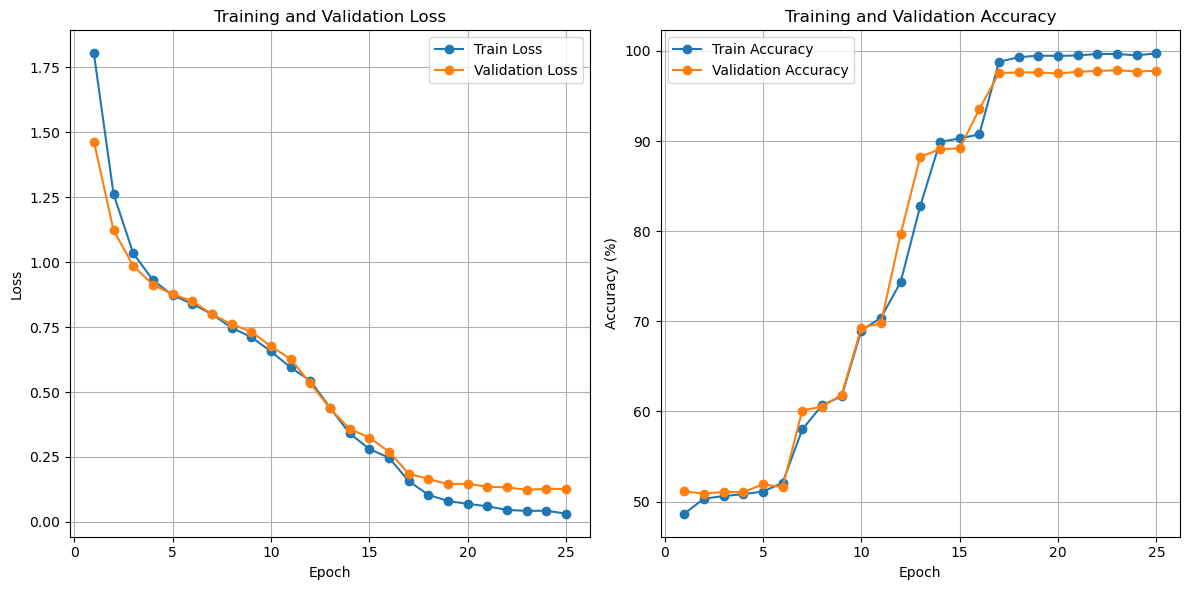

In [68]:
plot_training_history(history)

### 8. Evaluate

In [69]:
evaluate(
    model = model,
    data_loader = train_loader,  # evaluate on training data
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.0324, Accuracy: 99.68%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4735
           1       1.00      1.00      1.00      5383
           2       1.00      1.00      1.00      4762
           3       1.00      0.99      0.99      4886
           4       1.00      1.00      1.00      4681
           5       0.99      0.99      0.99      4368
           6       1.00      1.00      1.00      4752
           7       1.00      1.00      1.00      4983
           8       1.00      1.00      1.00      4674
           9       1.00      1.00      1.00      4776

    accuracy                           1.00     48000
   macro avg       1.00      1.00      1.00     48000
weighted avg       1.00      1.00      1.00     48000



In [70]:
evaluate(
    model = model,
    data_loader = val_loader,  # evaluate on validation data
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.1259, Accuracy: 97.81%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1188
           1       0.99      0.99      0.99      1359
           2       0.97      0.98      0.97      1196
           3       0.99      0.96      0.97      1245
           4       0.98      0.97      0.98      1161
           5       0.97      0.97      0.97      1053
           6       0.98      0.99      0.98      1166
           7       0.98      0.98      0.98      1282
           8       0.98      0.97      0.98      1177
           9       0.97      0.97      0.97      1173

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



In [71]:
evaluate(
    model = model,
    data_loader = test_loader,  # evaluate on testing data
    criterion = criterion,
    device = DEVICE,
)

Evaluation Results:
Loss: 0.1312, Accuracy: 97.74%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.97      0.97      0.97      1010
           4       0.99      0.98      0.98       982
           5       0.98      0.97      0.98       892
           6       0.98      0.99      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.98      0.97      0.97       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

